In [89]:
import os 
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import lightly

In [2]:
from multissl.models import MSRGBConvNeXtUPerNetMixed
from multissl.data.seg_transforms import JointTransform, ValidationJointTransform
from multissl.data.semantic_partial_dataset import MixedSupervisionSegmentationDataset, mixed_supervision_collate_fn

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import torch

# ============================================================================
# Create Sample Segmentation Mask (224x224 with 62 classes)
# ============================================================================

def create_sample_segmentation_mask(height=224, width=224, num_classes=62):
    """
    Create a sample segmentation mask with realistic patterns
    """
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Create some realistic segmentation patterns
    # Background (class 0)
    mask[:, :] = 0
    
    # Add some geometric shapes and regions for different classes
    np.random.seed(42)  # For reproducible results
    
    # Create random polygons and shapes
    for class_id in range(1, num_classes):
        # Random regions for each class
        for _ in range(np.random.randint(1, 4)):  # 1-3 regions per class
            # Random center point
            center_y = np.random.randint(20, height-20)
            center_x = np.random.randint(20, width-20)
            
            # Random size
            size_y = np.random.randint(10, 40)
            size_x = np.random.randint(10, 40)
            
            # Create region
            y1, y2 = max(0, center_y-size_y//2), min(height, center_y+size_y//2)
            x1, x2 = max(0, center_x-size_x//2), min(width, center_x+size_x//2)
            
            # Add some randomness to make it more realistic
            if np.random.random() > 0.3:  # 70% chance to add this region
                mask[y1:y2, x1:x2] = class_id
    
    return mask

# ============================================================================
# Visualization Methods
# ============================================================================

def create_colormap_for_classes(num_classes):
    """
    Create a distinctive colormap for segmentation classes
    """
    # Use a combination of different color schemes for maximum distinction
    colors = []
    
    # First add some standard colors
    base_colors = ['black', 'red', 'blue', 'green', 'yellow', 'cyan', 'magenta', 
                  'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy']
    
    for i, color in enumerate(base_colors):
        if i < num_classes:
            colors.append(color)
    
    # Generate additional colors using HSV space for better distribution
    remaining = num_classes - len(colors)
    if remaining > 0:
        hsv_colors = plt.cm.hsv(np.linspace(0, 1, remaining))
        colors.extend(hsv_colors)
    
    # Create custom colormap
    cmap = mcolors.ListedColormap(colors[:num_classes])
    return cmap

# Method 1: Basic imshow with custom colormap
def visualize_segmentation_basic(mask, num_classes=62):
    """Basic segmentation mask visualization"""
    plt.figure(figsize=(12, 10))
    
    cmap = create_colormap_for_classes(num_classes)
    
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.colorbar(label='Class ID', shrink=0.8)
    plt.title(f'Segmentation Mask ({mask.shape[0]}x{mask.shape[1]}, {num_classes} classes)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Method 2: Enhanced visualization with class statistics
def visualize_segmentation_enhanced(mask, num_classes=62, class_names=None):
    """Enhanced segmentation visualization with statistics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Create colormap
    cmap = create_colormap_for_classes(num_classes)
    
    # Main segmentation plot
    im = ax1.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    ax1.set_title(f'Segmentation Mask ({mask.shape[0]}×{mask.shape[1]})')
    ax1.axis('off')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label('Class ID', rotation=270, labelpad=15)
    
    # Class distribution histogram
    unique_classes, counts = np.unique(mask, return_counts=True)
    ax2.bar(unique_classes, counts, color=[cmap(i/num_classes) for i in unique_classes])
    ax2.set_xlabel('Class ID')
    ax2.set_ylabel('Pixel Count')
    ax2.set_title('Class Distribution')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text
    total_pixels = mask.size
    non_background = np.sum(mask > 0) if 0 in unique_classes else total_pixels
    stats_text = f"Total pixels: {total_pixels:,}\n"
    stats_text += f"Background pixels: {total_pixels - non_background:,}\n"
    stats_text += f"Foreground pixels: {non_background:,}\n"
    stats_text += f"Active classes: {len(unique_classes)}/{num_classes}"
    
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Method 3: Multiple visualization modes
def visualize_segmentation_comprehensive(mask, num_classes=62):
    """Comprehensive segmentation visualization"""
    fig = plt.figure(figsize=(20, 12))
    
    # Create colormap
    cmap = create_colormap_for_classes(num_classes)
    
    # 1. Original mask
    ax1 = plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title('Original Segmentation Mask')
    plt.axis('off')
    plt.colorbar(shrink=0.8)
    
    # 2. Binary mask (foreground vs background)
    ax2 = plt.subplot(2, 3, 2)
    binary_mask = (mask > 0).astype(np.uint8)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask (Foreground/Background)')
    plt.axis('off')
    plt.colorbar(shrink=0.8)
    
    # 3. Class boundaries
    ax3 = plt.subplot(2, 3, 3)
    # Create boundary map
    from scipy import ndimage
    boundaries = ndimage.sobel(mask.astype(float))
    plt.imshow(boundaries, cmap='hot')
    plt.title('Class Boundaries')
    plt.axis('off')
    plt.colorbar(shrink=0.8)
    
    # 4. Class distribution
    ax4 = plt.subplot(2, 3, 4)
    unique_classes, counts = np.unique(mask, return_counts=True)
    colors = [cmap(i/num_classes) for i in unique_classes]
    plt.bar(unique_classes, counts, color=colors)
    plt.xlabel('Class ID')
    plt.ylabel('Pixel Count')
    plt.title('Class Distribution')
    plt.yscale('log')  # Log scale for better visualization
    plt.grid(True, alpha=0.3)
    
    # 5. Top classes only
    ax5 = plt.subplot(2, 3, 5)
    # Show only classes with significant pixel counts
    significant_mask = counts > np.percentile(counts, 75)  # Top 25% of classes
    sig_classes = unique_classes[significant_mask]
    sig_counts = counts[significant_mask]
    sig_colors = [cmap(i/num_classes) for i in sig_classes]
    
    plt.bar(range(len(sig_classes)), sig_counts, color=sig_colors)
    plt.xlabel('Top Classes')
    plt.ylabel('Pixel Count')
    plt.title('Most Prominent Classes')
    plt.xticks(range(len(sig_classes)), sig_classes)
    plt.grid(True, alpha=0.3)
    
    # 6. Class presence map
    ax6 = plt.subplot(2, 3, 6)
    presence_matrix = np.zeros((8, 8))  # 8x8 grid for 64 classes
    for i, class_id in enumerate(range(num_classes)):
        row, col = i // 8, i % 8
        if row < 8 and col < 8:
            presence_matrix[row, col] = 1 if class_id in unique_classes else 0
    
    plt.imshow(presence_matrix, cmap='RdYlBu_r', aspect='equal')
    plt.title('Class Presence Grid')
    plt.xlabel('Class ID (mod 8)')
    plt.ylabel('Class ID (div 8)')
    
    # Add text annotations
    for i in range(8):
        for j in range(8):
            class_id = i * 8 + j
            if class_id < num_classes:
                color = 'white' if presence_matrix[i, j] > 0.5 else 'black'
                plt.text(j, i, str(class_id), ha='center', va='center', 
                        color=color, fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Method 4: PyTorch tensor visualization
def visualize_torch_segmentation(mask_tensor, num_classes=62):
    """Visualize segmentation mask from PyTorch tensor"""
    if isinstance(mask_tensor, torch.Tensor):
        mask_np = mask_tensor.cpu().numpy()
        
        # Handle different tensor shapes
        if mask_np.ndim == 4:  # (B, C, H, W) or (B, 1, H, W)
            mask_np = mask_np[0, 0]  # Take first batch, first channel
        elif mask_np.ndim == 3:  # (C, H, W) or (1, H, W)
            mask_np = mask_np[0] if mask_np.shape[0] == 1 else mask_np
        
        print(f"Tensor shape: {mask_tensor.shape} -> Numpy shape: {mask_np.shape}")
        
        visualize_segmentation_enhanced(mask_np.astype(np.uint8), num_classes)
    else:
        print("Input is not a PyTorch tensor")

# ============================================================================
# Utility Functions
# ============================================================================

def save_segmentation_visualization(mask, filename, num_classes=62, dpi=300):
    """Save high-quality segmentation visualization"""
    plt.figure(figsize=(10, 10))
    cmap = create_colormap_for_classes(num_classes)
    
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Segmentation mask saved to {filename}")

def overlay_segmentation_on_image(image, mask, alpha=0.5, num_classes=62):
    """Overlay segmentation mask on original image"""
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have same spatial dimensions")
    
    plt.figure(figsize=(15, 5))
    cmap = create_colormap_for_classes(num_classes)
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Segmentation mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title('Segmentation Mask')
    plt.axis('off')
    plt.colorbar(shrink=0.8)
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap=cmap, alpha=alpha, vmin=0, vmax=num_classes-1)
    plt.title(f'Overlay (α={alpha})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [49]:

args = {"backbone_path":None, #"../checkpoints_convnextms_smote/fastsiam_multi_convnext_tiny_2epoch.ckpt",
        "state_dict_path": "./treeai_checkpoints/pasiphae_30M_treeai_state_dict.pth",
        "num_classes": 62, #61 types + 0 background
        "freeze_backbone": True,
        "batch_size": 8,
        "img_size": 640,
        "model_size": "tiny",
        "rgb_in_channels": 3, #pretrained backbone setting
        "ms_in_channels": 5,#pretrained backbone setting
        "model_size":"tiny", # Can be 'tiny', 'small', 'base', 'large' #pretrained backbone setting
        "learning_rate": 1e-5,
        "weight_decay": 1e-4,
        "epochs": 15,

        "fully_labeled_dir_train" : "../dataset/TreeAI/12_RGB_SemSegm_640_fL/train",
        "partially_labeled_dir_train": "../dataset/TreeAI/34_RGB_SemSegm_640_pL/train",
        "fully_labeled_dir_val" : "../dataset/TreeAI/12_RGB_SemSegm_640_fL/val",
        "partially_labeled_dir_val" :  "../dataset/TreeAI/34_RGB_SemSegm_640_pL/val",
        "ignore_index" : 255, # probably just background class too :(
        "balance_supervision" :  False,
        "partial_label_ratio":  0.5, # W"
        "reduce_dataset": None,
                # Mixed supervision parameters
        "full_supervision_weight" :1.0,
        "partial_supervision_weight" :0.3,
        "consistency_weight" :0.2,
        "use_consistency_loss" :True,
       }



In [50]:

pl_model =  MSRGBConvNeXtUPerNetMixed(
        num_classes=args["num_classes"],  # Binary segmentation (background, foreground)
        rgb_in_channels=args["rgb_in_channels"],
        ms_in_channels=args["ms_in_channels"],
        model_size=args['model_size'], 
        learning_rate=args["learning_rate"],
        weight_decay=args["weight_decay"],
        pretrained_backbone=args["backbone_path"],  # Path to pretrained weights if available
        freeze_backbone = args["freeze_backbone"],
        full_supervision_weight =args["full_supervision_weight"],
        partial_supervision_weight = args["partial_supervision_weight"],
        consistency_weight  =args["consistency_weight"] ,
        use_consistency_loss = args["use_consistency_loss"],
    )
pl_model.load_state_dict(torch.load(args["state_dict_path"]))
pl_model.eval()

MSRGBConvNeXtUPerNetMixed(
  (backbone): MSRGBConvNeXtFeatureExtractor(
    (backbone): MSRGBConvNeXt(
      (stem): AdaptiveStem(
        (rgb_stem): Sequential(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (ms_stem): Sequential(
          (0): Conv2d(5, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (adapter): ModalityAdapter(
          (rgb_adapter): Sequential(
            (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
            (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm

In [103]:
test_folder = "../dataset/TreeAI/SemSeg_test-images/"

# Basic transform
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = lightly.data.LightlyDataset(test_folder, transform = transform)


In [128]:
from tqdm import tqdm
with torch.no_grad():
    result_list = []
    for sample, target, fname in tqdm(dataset):
        s= sample.unsqueeze(dim=0)
        f = fname.strip(".png")
        
        logits = pl_model.forward(rgb =s )
        pred_mask = logits.argmax(dim=1)
        result_list.append({"img": sample, "mask":pred_mask.squeeze()})
        numpy_array = pred_mask.squeeze().detach().cpu().numpy()
        out_filename = os.path.join("outputs_pasiphae_treeai",f'{f}.npy' )
        np.save(out_filename, numpy_array)
        

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [02:40<00:00,  1.01s/it]


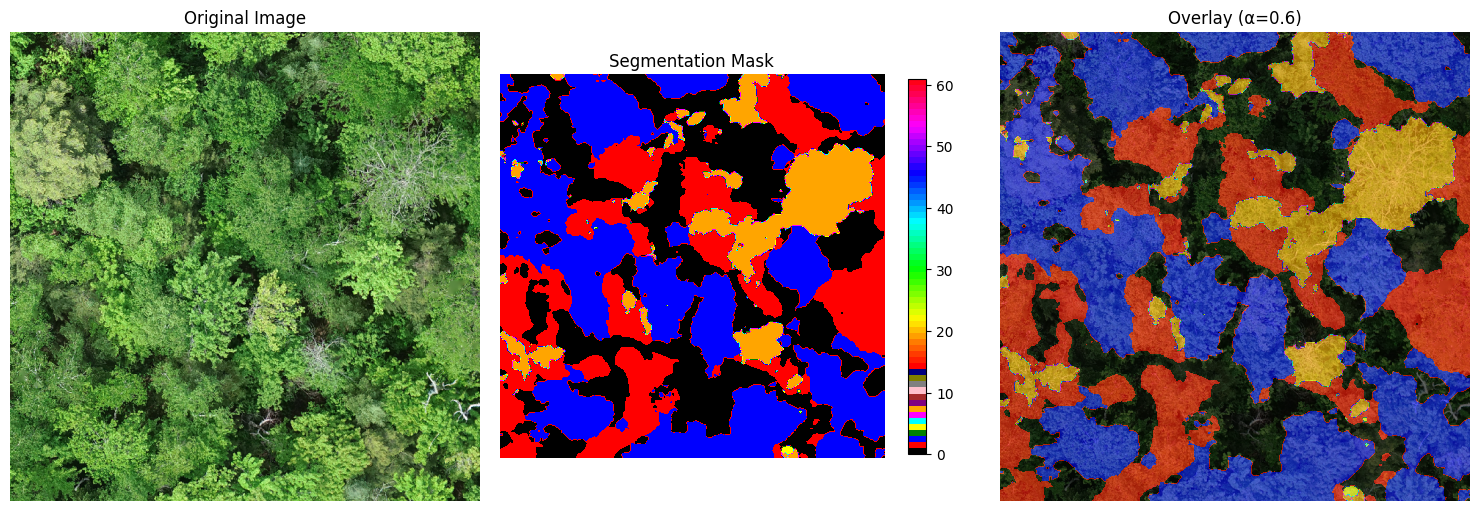

In [129]:
# Example with dummy image
overlay_segmentation_on_image(result_list[15]["img"].permute(1,2,0),result_list[15]["mask"], alpha=0.6, num_classes=62)


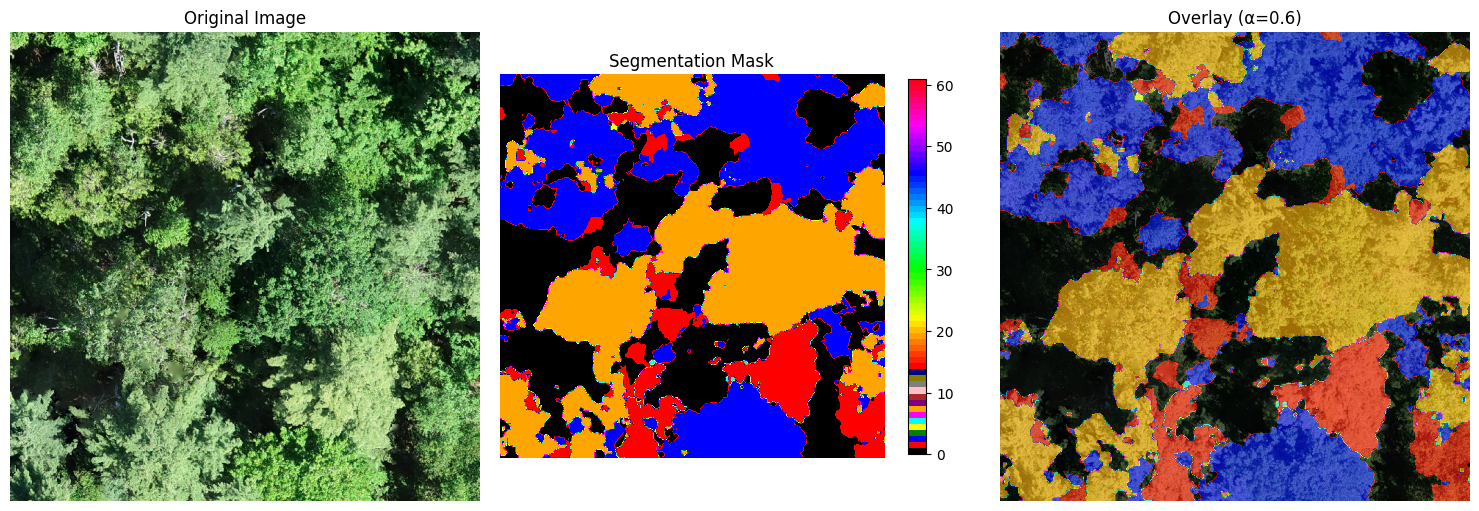

In [130]:
overlay_segmentation_on_image(result_list[45]["img"].permute(1,2,0),result_list[45]["mask"], alpha=0.6, num_classes=62)


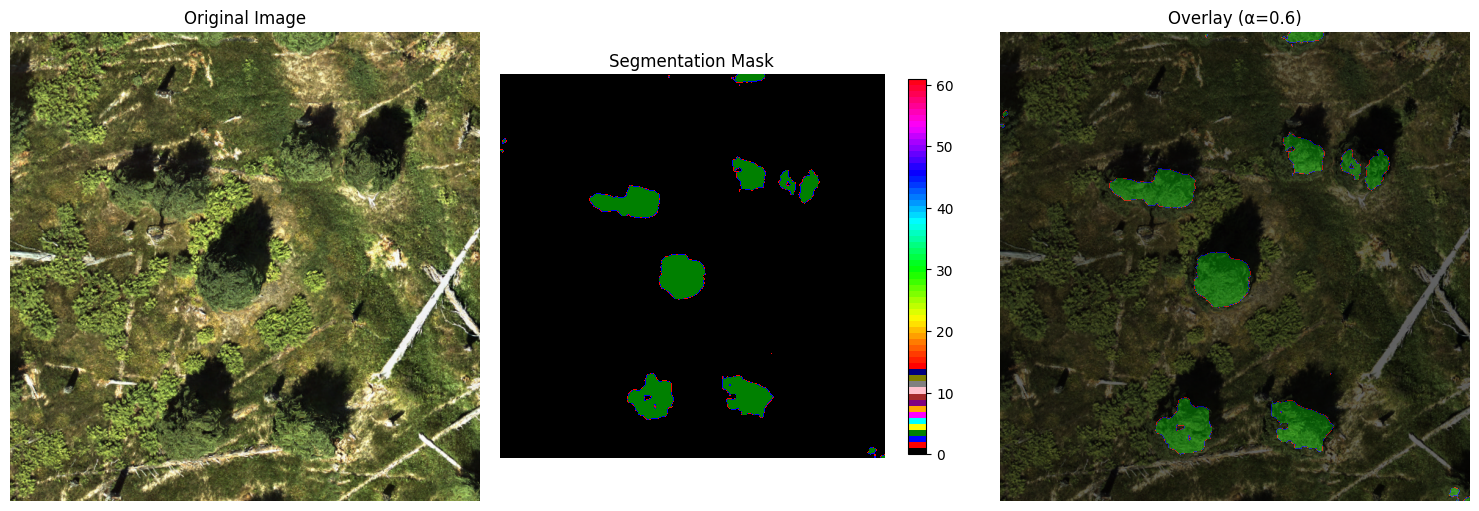

In [131]:
overlay_segmentation_on_image(result_list[150]["img"].permute(1,2,0),result_list[150]["mask"], alpha=0.6, num_classes=62)
